this code is a first pass at pre-processing a chemi-informatics dataset
dont forget to log transform output vals

In [2]:
import pandas as pd
import json

# Load dataset
df = pd.read_csv('20240729merged_stat_resp.csv')
print(df.head())

   conc_resp_assay_id  conc_resp_element_id    exp_id     nsc  log_hi_conc  \
0            13342897              66609633  1702NS56  795222           -4   
1            13342897              66609634  1702NS56  795222           -4   
2            13342897              66609635  1702NS56  795222           -4   
3            13342897              66609636  1702NS56  795222           -4   
4            13342897              66609637  1702NS56  795222           -4   

  conc_unit  assay_time  cas_number  cas_string discreet  ...  count_giprcnt  \
0         M           2         NaN         NaN        N  ...              1   
1         M           2         NaN         NaN        N  ...              1   
2         M           2         NaN         NaN        N  ...              1   
3         M           2         NaN         NaN        N  ...              1   
4         M           2         NaN         NaN        N  ...              1   

                                       smiles mean

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44109 entries, 0 to 44108
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   conc_resp_assay_id     44109 non-null  int64  
 1   conc_resp_element_id   44109 non-null  int64  
 2   exp_id                 44109 non-null  object 
 3   nsc                    44109 non-null  int64  
 4   log_hi_conc            44109 non-null  int64  
 5   conc_unit              44109 non-null  object 
 6   assay_time             44109 non-null  int64  
 7   cas_number             0 non-null      float64
 8   cas_string             0 non-null      float64
 9   discreet               44109 non-null  object 
 10  drug_name              0 non-null      float64
 11  nsc_compound_namecode  44109 non-null  object 
 12  target                 44109 non-null  object 
 13  line_name              44109 non-null  object 
 14  concentration          44109 non-null  int64  
 15  me

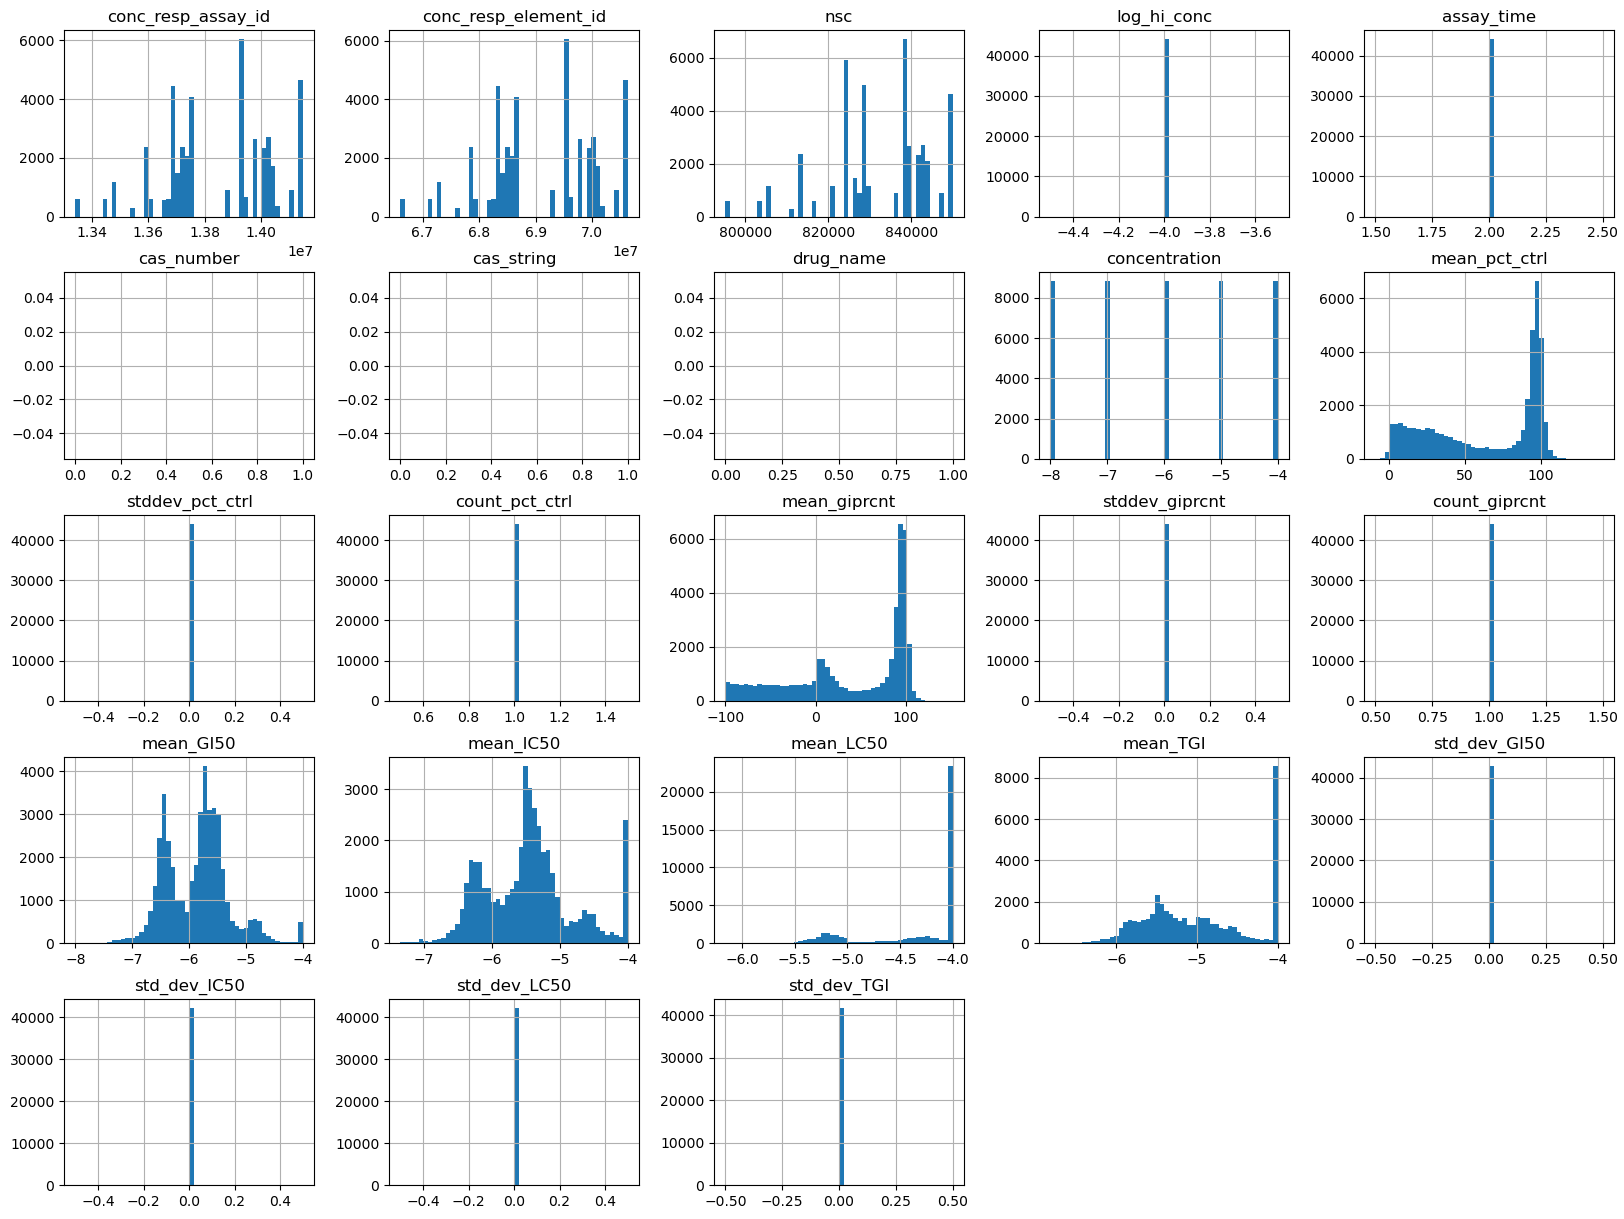

In [10]:
df.info()

%matplotlib inline
import matplotlib.pyplot as plt

df.hist(bins=50, figsize=(20,15))
plt.show()

In [4]:
#drop cols that I don't need for modeling 
drop_cols = ['conc_resp_assay_id', 'conc_resp_element_id', 'exp_id', 'nsc', 'conc_unit', 
                'assay_time', 'log_hi_conc', 'cas_number', 'cas_string', 'discreet', 'drug_name',
                'nsc_compound_namecode', 'target', 'concentration', 'mean_pct_ctrl', 'stddev_pct_ctrl',
                'count_pct_ctrl', 'mean_giprcnt', 'stddev_giprcnt', 'count_giprcnt', 'mean_GI50',
                'mean_LC50', 'mean_TGI', 'std_dev_GI50', 'std_dev_IC50', 'std_dev_LC50', 'std_dev_TGI'
]

prepro_df = df.drop(columns=drop_cols)
print(prepro_df.head())

  line_name                                      smiles  mean_IC50
0     786-0  Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1       -4.0
1     786-0  Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1       -4.0
2     786-0  Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1       -4.0
3     786-0  Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1       -4.0
4     786-0  Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1       -4.0


Now that I have a dataframe with an index, line_name, smiles, and IC50. I can log transform the IC50 values. and then use eClean components to curate my SMILES list. Last, I need to convert to molecular fingerprints

In [5]:
#convert ic50 values to positive because for some reason they were all negative
prepro_df['mean_IC50']= prepro_df['mean_IC50'].apply(np.abs)

#  to pIC50 log transform values in mean_IC50 column and used log1p to transform the values
prepro_df['mean_pIC50']=np.log1p(prepro_df['mean_IC50'])

print(prepro_df.head())



print(f"Dataframe written to proj path in {file_path}")


NameError: name 'np' is not defined

In [20]:
file_path = r"C:\Users\Jackie\Desktop\NCI_screen\nci_screen_csv\preprocess_data_nci.csv"
# read df and drop duplicates
prepro_df = pd.read_csv(file_path).drop_duplicates(["line_name", "smiles"])

In [7]:
with open(r"C:\Users\Jackie\Desktop\NCI_screen\nci_screen_csv\model.json", "r") as f:
    model = json.load(f)
    result_smiles_col = (
        model["structure_col"] if model["structure_type"] == "smiles" else "SMILES"
    )
    result_mol_col = (
        model["structure_col"] if model["structure_type"] == "mol" else "ROMol"
    )

In [8]:
from eclean_components import dataframe_cleanup
from eclean_components import chem_cleanup

# get unique smile strings from df
unique_smiles = prepro_df.smiles.unique().tolist()

unique_moles = {
    smile: dataframe_cleanup._molFromSmiles(smile) for smile in unique_smiles
}
# make dictionary with keys as orig smile strs and values are canonical smiles
canonical_smiles = {
    smile: dataframe_cleanup._molToSmiles(mol) for smile, mol in unique_moles.items()
}

# make new column of mol objects
prepro_df.loc[:, result_mol_col] = prepro_df["smiles"].apply(lambda x: unique_moles[x])
# replace smiles with canonical smiles by applying dictionary lookup to whole column
prepro_df.loc[:, result_smiles_col] = prepro_df["smiles"].apply(lambda x: canonical_smiles[x])


Exception: SMILES nan could not be parsed
Exception: Mol to SMILES conversion failed


,line_name,smiles,mean_IC50,mean_pIC50,Smiles,ROMol
0,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0000,1.609438,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
10,A498,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.1316,1.635418,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
20,A549/ATCC,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,5.4904,1.870324,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
30,ACHN,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0000,1.609438,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
40,BT-549,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0000,1.609438,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
...,...,...,...,...,...,...
44084,TK-10,CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4,5.1437,1.815427,CNC(=O)c1c(NC(=O)c2ccc(-c3ccccc3)cc2)sc2c1CCC(...,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
44089,U251,CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4,6.4806,2.012313,CNC(=O)c1c(NC(=O)c2ccc(-c3ccccc3)cc2)sc2c1CCC(...,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
44094,UACC-257,CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4,5.2855,1.838245,CNC(=O)c1c(NC(=O)c2ccc(-c3ccccc3)cc2)sc2c1CCC(...,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...
44099,UACC-62,CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4,5.8123,1.918730,CNC(=O)c1c(NC(=O)c2ccc(-c3ccccc3)cc2)sc2c1CCC(...,<rdkit.Chem.rdchem.Mol object at 0x0000028486A...


In [17]:
cleaned = chem_cleanup._remove_fragments(
    prepro_df,
    result_smiles_col,
    result_mol_col,
    False,
    None
)

cleaned.head()

Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be parsed
Exception: SMILES nan could not be

,line_name,smiles,mean_IC50,ROMol,Smiles
0,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,-4.0,<rdkit.Chem.rdchem.Mol object at 0x000002D133C...,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O
1,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,-4.0,<rdkit.Chem.rdchem.Mol object at 0x000002D133C...,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O
2,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,-4.0,<rdkit.Chem.rdchem.Mol object at 0x000002D133C...,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O
3,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,-4.0,<rdkit.Chem.rdchem.Mol object at 0x000002D133C...,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O
4,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,-4.0,<rdkit.Chem.rdchem.Mol object at 0x000002D133C...,Cc1ccn2c3c(c(C(=O)O)c2c1)C(=O)c1ccccc1C3=O


Curated SMILES, need to drop NAs

In [18]:
from sklearn.preprocessing import OneHotEncoder

# Define encoder and fit and transform line-name
encoder = OneHotEncoder(sparse_output=False)
encoded = encoder.fit_transform(cleaned[['line_name']])

# Convert back to pandas dataframe
cleaned_encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['line_name']))
df_encoded = pd.concat([cleaned, cleaned_encoded_df], axis=1).drop(columns=['line_name'])
print(df_encoded)


                                                 smiles  mean_IC50  \
0            Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1    -4.0000   
1            Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1    -4.0000   
2            Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1    -4.0000   
3            Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1    -4.0000   
4            Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1    -4.0000   
...                                                 ...        ...   
44104  CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4    -6.2491   
44105  CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4    -6.2491   
44106  CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4    -6.2491   
44107  CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4    -6.2491   
44108  CNC(=O)c1c2CCC(=O)Cc2sc1NC(=O)c3ccc(cc3)c4ccccc4    -6.2491   

                                                   ROMol  \
0      <rdkit.Chem.rdchem.Mol object at 0x000002D133C...   
1      <rdkit.Chem.rdchem.Mol object at

Ignore code below. So^ I thought I had to covert these canonicalized and cleaned smiles to fps but this code is in the megamodels example script. so i just need to onehot encode my line_name info b/c ML cannot handle categorical data

In [8]:
import numpy as np
import pandas as pd
import json
import os.path
from eclean_components import dataframe_cleanup
from eclean_components import chem_cleanup

def canonicalize_smiles_mod(df, structure_type='smiles', structure_col='smiles', result_smiles_col='SMILES', result_mol_col='ROMol'):

    if structure_type=='mol':
            df[result_smiles_col] = [_molToSmiles(mol) for mol in df[structure_col]]
    else:

        # If not mol, structure_type=='smiles':
        df[result_smiles_col] = [_molToSmiles(_molFromSmiles(smile)) for smile in df[structure_col]]

    return df.dropna(subset=[result_smiles_col])

data_file = r"C:\Users\Jackie\Desktop\NCI_screen\nci_screen_csv\preprocess_data_nci.csv"
model_json = r"C:\Users\Jackie\Desktop\NCI_screen\nci_screen_csv\model.json"

def read_file(data_file):
    extension = os.path.splitext(data_file)[1]
    if extension == ".csv":
        data_df = pd.read_csv(data_file, sep=",")
    elif extension == ".tsv":
        data_df = pd.read_csv(data_file, sep="\t")
    elif extension == ".xlsx":
        data_df = pd.read_excel(data_file)
    return data_df

def eClean(data_file, model_json):
    """Sample calling method to execute the cleaning steps in the same
    order and way that eClean website does

    Args:
        data_file (str): String with the path to the data file (CSV, TSV or Excel)
        model_json (json file path): Cleaning configuration packaged as a JSON file.
        This packaging is arbitrary, cleaning functions can be called independant of
        a model file

    Returns:
        DataFrame: cleaned dataframe
    """
    with open(model_json) as f:
            model = json.load(f)

    data_df = read_file(data_file)
    
    #data_df = data_df.dropna(subset=[smiles])
    #data cleaning
    #df_clean = dataframe_cleanup.drop_na(
            #data_df,
           # structure_col=data_df["smiles"],
           # target_col=data_df["mean_pIC50"],
           # remove_na_targets=model["format_settings"]["remove_na_targets"],
      #  )
    result_smiles_col = (
            model["structure_col"] if model["structure_type"] == "smiles" else "SMILES"
        )
    result_mol_col = (
            model["structure_col"] if model["structure_type"] == "mol" else "ROMol"
        )

    df_clean = dataframe_cleanup.canonicalize_smiles(
            datadrop_df,
            structure_type=model["structure_type"],
            structure_col="smiles",
            result_smiles_col=result_smiles_col,
            result_mol_col=reslt_mol_col,
        )

    df_clean = chem_cleanup.chem_cleanup(
            df_clean,
            smiles_col=result_smiles_col,
            mol_col=result_mol_col,
            desalt=model["chem_settings"]["desalt"],
            filter_method=model["chem_settings"]["fragment_filter"],
            neutralize_charge=model["chem_settings"]["neutralize_charge"],
        )
    return df_clean

cleaned_df = eClean(data_file, model_json)


c:\Users\Jackie\Desktop\NCI_screen\.conda\Lib\site-packages\eclean_components\dataframe_cleanup.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[result_mol_col]    = [_molFromSmiles(smile) for smile in df[structure_col]]


In [6]:
import numpy as np
import pandas as pd
import json
import os.path
from eclean_components import dataframe_cleanup
from eclean_components import chem_cleanup

def read_file(data_file):
    extension = os.path.splitext(data_file)[1]
    if extension == ".csv":
        data_df = pd.read_csv(data_file, sep=",")
    elif extension == ".tsv":
        data_df = pd.read_csv(data_file, sep="\t")
    elif extension == ".xlsx":
        data_df = pd.read_excel(data_file)
    return data_df

data_file = r"C:\Users\Jackie\Desktop\NCI_screen\nci_screen_csv\preprocess_data_nci.csv"
data_df = read_file(data_file)

datadrop_df = data_df.dropna(subset=['smiles'])
datadrop_df.head()


,line_name,smiles,mean_IC50,mean_pIC50
0,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0,1.609438
1,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0,1.609438
2,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0,1.609438
3,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0,1.609438
4,786-0,Cc1ccn2c3C(=O)c4ccccc4C(=O)c3c(C(=O)O)c2c1,4.0,1.609438
